# Vanna-Volga Pricing for Barrier Options

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import math


Down-in Call Prices:
Spot Price     Vanilla Price       Barrier Price       
80.00          0.6027              0.0000              
85.56          1.2648              0.0000              
91.11          2.3500              0.0000              
96.67          3.9532              0.0000              
102.22         6.1295              0.0000              
107.78         8.8887              0.0000              
113.33         12.1993             0.0000              
118.89         16.0002             0.0000              
124.44         20.2149             0.0000              
130.00         24.7630             0.0000              

Down-out Call Prices:
Spot Price     Vanilla Price       Barrier Price       
80.00          0.6027              0.6027              
85.56          1.2648              1.2648              
91.11          2.3500              2.3500              
96.67          3.9532              3.9532              
102.22         6.1295              6.1295              
107

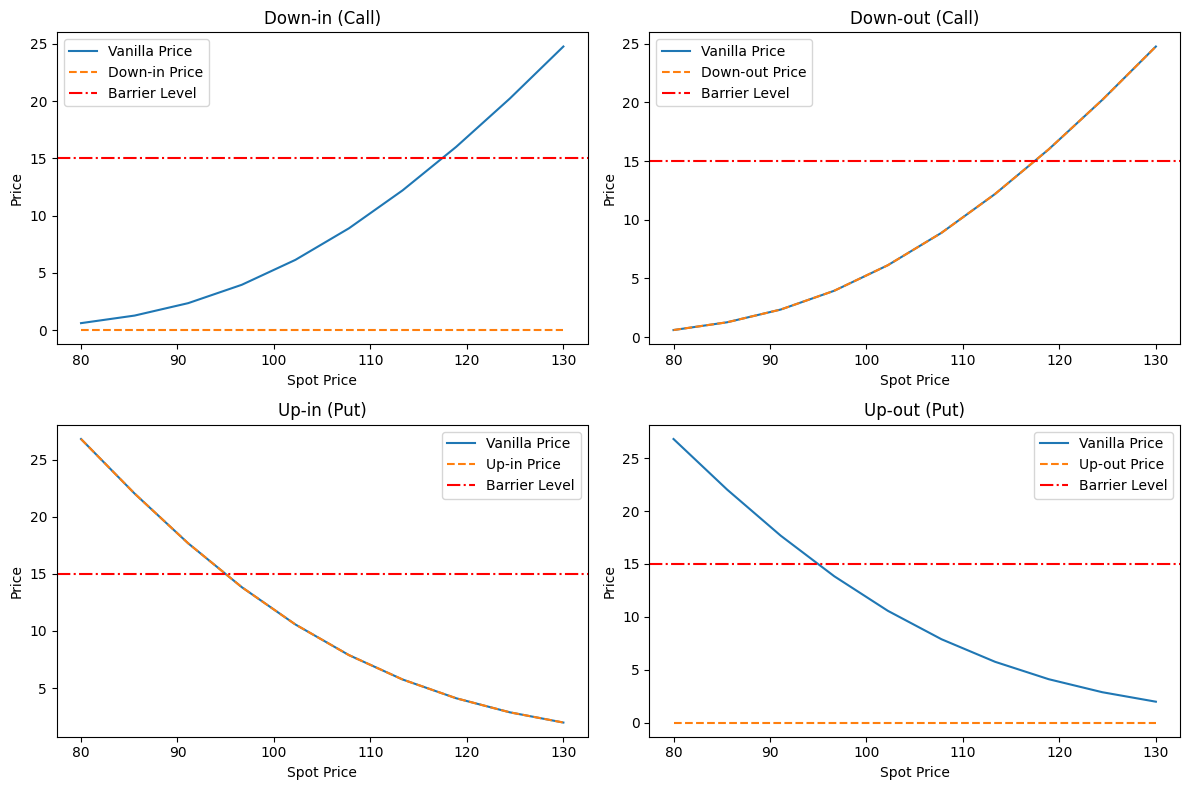

In [71]:
class FXBarrierOption:
    def __init__(self, spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=None, barrier_type=None, option_type='call'):
        """
        Initialize the FXBarrierOption class with parameters.
        """
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.time_to_maturity = time_to_maturity
        self.volatility = volatility
        self.domestic_rate = domestic_rate
        self.foreign_rate = foreign_rate
        self.barrier_level = barrier_level
        self.barrier_type = barrier_type
        self.option_type = option_type.lower()

        if self.option_type not in ['call', 'put']:
            raise ValueError("option_type must be either 'call' or 'put'.")

    def compute_d1(self, spot_price=None):
        S = spot_price if spot_price else self.spot_price
        K = self.strike_price
        T = self.time_to_maturity
        r_d = self.domestic_rate
        r_f = self.foreign_rate
        sigma = self.volatility

        d1 = (math.log(S / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
        return d1

    def compute_d2(self, d1=None):
        if d1 is None:
            d1 = self.compute_d1()
        return d1 - self.volatility * math.sqrt(self.time_to_maturity)

    def calculate_vanilla_price(self):
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)
        S = self.spot_price
        K = self.strike_price
        T = self.time_to_maturity
        r_d = self.domestic_rate
        r_f = self.foreign_rate

        if self.option_type == 'call':
            price = (S * math.exp(-r_f * T) * norm.cdf(d1)) - (K * math.exp(-r_d * T) * norm.cdf(d2))
        elif self.option_type == 'put':
            price = (K * math.exp(-r_d * T) * norm.cdf(-d2)) - (S * math.exp(-r_f * T) * norm.cdf(-d1))
        
        return price

    def calculate_barrier_price(self):
        if self.barrier_type is None or self.barrier_level is None:
            raise ValueError("Barrier level and type must be specified for barrier options.")

        if self.barrier_type == 'down-in':
            return self._down_and_in_price()
        elif self.barrier_type == 'down-out':
            return self._down_and_out_price()
        elif self.barrier_type == 'up-in':
            return self._up_and_in_price()
        elif self.barrier_type == 'up-out':
            return self._up_and_out_price()
        else:
            raise ValueError(f"Unsupported barrier type: {self.barrier_type}")

    def _down_and_in_price(self):
        vanilla_price = self.calculate_vanilla_price()
        if self.spot_price <= self.barrier_level:
            return vanilla_price
        else:
            return 0

    def _down_and_out_price(self):
        vanilla_price = self.calculate_vanilla_price()
        if self.spot_price <= self.barrier_level:
            return 0
        else:
            return vanilla_price

    def _up_and_in_price(self):
        vanilla_price = self.calculate_vanilla_price()
        if self.spot_price >= self.barrier_level:
            return vanilla_price
        else:
            return 0

    def _up_and_out_price(self):
        vanilla_price = self.calculate_vanilla_price()
        if self.spot_price >= self.barrier_level:
            return 0
        else:
            return vanilla_price


def visualize_and_print_all_barrier_options():
    # Common parameters
    strike_price = 110
    time_to_maturity = 1  # in years
    volatility = 0.2
    domestic_rate = 0.05
    foreign_rate = 0.02

    # Barrier levels
    barrier_level_down = 15
    barrier_level_up = 15

    # Spot prices for visualization
    spot_prices = np.linspace(80, 130, 10)

    # Barrier option types and their configurations
    barrier_options = [
        {'type': 'down-in', 'barrier': barrier_level_down, 'option_type': 'call'},
        {'type': 'down-out', 'barrier': barrier_level_down, 'option_type': 'call'},
        {'type': 'up-in', 'barrier': barrier_level_up, 'option_type': 'put'},
        {'type': 'up-out', 'barrier': barrier_level_up, 'option_type': 'put'},
    ]

    # Visualize each barrier type
    plt.figure(figsize=(12, 8))
    for idx, config in enumerate(barrier_options, 1):
        option = FXBarrierOption(
            None, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, 
            barrier_level=config['barrier'], barrier_type=config['type'], option_type=config['option_type']
        )

        # Lists to store results
        vanilla_prices = []
        barrier_prices = []

        print(f"\n{config['type'].capitalize()} {config['option_type'].capitalize()} Prices:")
        print(f"{'Spot Price':<15}{'Vanilla Price':<20}{'Barrier Price':<20}")

        # Calculate prices for each spot price
        for spot in spot_prices:
            option.spot_price = spot
            vanilla_price = option.calculate_vanilla_price()
            barrier_price = option.calculate_barrier_price()

            vanilla_prices.append(vanilla_price)
            barrier_prices.append(barrier_price)

            # Print the prices
            print(f"{spot:<15.2f}{vanilla_price:<20.4f}{barrier_price:<20.4f}")

        # Plot
        plt.subplot(2, 2, idx)
        plt.plot(spot_prices, vanilla_prices, label='Vanilla Price', linestyle='-')
        plt.plot(spot_prices, barrier_prices, label=f"{config['type'].capitalize()} Price", linestyle='--')
        plt.axhline(y=config['barrier'], color='red', linestyle='-.', label='Barrier Level')
        plt.title(f"{config['type'].capitalize()} ({config['option_type'].capitalize()})")
        plt.xlabel('Spot Price')
        plt.ylabel('Price')
        plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    visualize_and_print_all_barrier_options()

Vanilla Price: 5.1886
Vanna: 43.1733
Volga: 18.4156
Vanna-Volga Adjusted Price: 10.4267


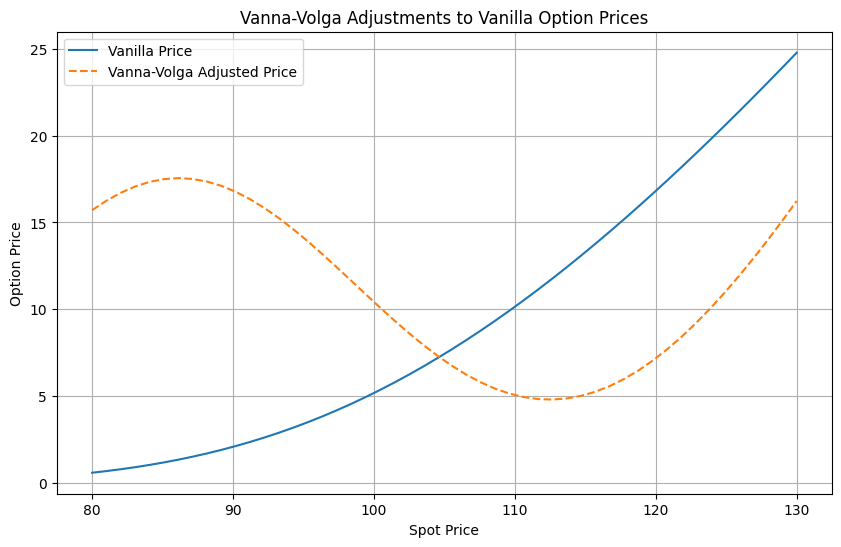

Spot Price     Vanilla Price       VV Adjusted Price   
80.00          0.6027              15.7085             
81.02          0.6977              16.2529             
82.04          0.8039              16.7093             
83.06          0.9219              17.0713             
84.08          1.0525              17.3337             
85.10          1.1964              17.4935             
86.12          1.3543              17.5490             
87.14          1.5270              17.5004             
88.16          1.7150              17.3498             
89.18          1.9190              17.1005             
90.20          2.1396              16.7578             
91.22          2.3773              16.3282             
92.24          2.6327              15.8196             
93.27          2.9062              15.2408             
94.29          3.1981              14.6018             
95.31          3.5089              13.9131             
96.33          3.8389              13.1858      

In [74]:
import math
from scipy.stats import norm


class FXBarrierOptionVV:
    def __init__(self, spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=None, barrier_type=None, option_type='call'):
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.time_to_maturity = time_to_maturity
        self.volatility = volatility
        self.domestic_rate = domestic_rate
        self.foreign_rate = foreign_rate
        self.barrier_level = barrier_level
        self.barrier_type = barrier_type
        self.option_type = option_type.lower()

    def compute_d1(self):
        S = self.spot_price
        K = self.strike_price
        T = self.time_to_maturity
        r_d = self.domestic_rate
        r_f = self.foreign_rate
        sigma = self.volatility
        d1 = (math.log(S / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
        return d1

    def compute_d2(self, d1=None):
        if d1 is None:
            d1 = self.compute_d1()
        return d1 - self.volatility * math.sqrt(self.time_to_maturity)

    def calculate_vanilla_price(self):
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)
        S = self.spot_price
        K = self.strike_price
        T = self.time_to_maturity
        r_d = self.domestic_rate
        r_f = self.foreign_rate

        if self.option_type == 'call':
            price = (S * math.exp(-r_f * T) * norm.cdf(d1)) - (K * math.exp(-r_d * T) * norm.cdf(d2))
        elif self.option_type == 'put':
            price = (K * math.exp(-r_d * T) * norm.cdf(-d2)) - (S * math.exp(-r_f * T) * norm.cdf(-d1))
        return price

    def calculate_vanna(self):
        d1 = self.compute_d1()
        T = self.time_to_maturity
        sigma = self.volatility
        return -self.spot_price * math.exp(-self.foreign_rate * T) * norm.pdf(d1) * d1 / sigma

    def calculate_volga(self):
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)
        T = self.time_to_maturity
        sigma = self.volatility
        return self.spot_price * math.exp(-self.foreign_rate * T) * norm.pdf(d1) * d1 * d2 / sigma

    def calculate_vv_adjusted_price(self, w_vanna, w_volga):
        vanilla_price = self.calculate_vanilla_price()
        vanna = self.calculate_vanna()
        volga = self.calculate_volga()
        adjusted_price = vanilla_price + w_vanna * vanna + w_volga * volga
        return adjusted_price
    
    
# Test Vanna-Volga Adjustments
option = FXBarrierOptionVV(
    spot_price=100, strike_price=110, time_to_maturity=1, volatility=0.2,
    domestic_rate=0.05, foreign_rate=0.02, barrier_type='up-out', option_type='call'
)

vanilla_price = option.calculate_vanilla_price()
vanna = option.calculate_vanna()
volga = option.calculate_volga()
vv_adjusted_price = option.calculate_vv_adjusted_price(w_vanna=0.1, w_volga=0.05)

print(f"Vanilla Price: {vanilla_price:.4f}")
print(f"Vanna: {vanna:.4f}")
print(f"Volga: {volga:.4f}")
print(f"Vanna-Volga Adjusted Price: {vv_adjusted_price:.4f}")
def test_vanna_volga_adjustments():
    # Common parameters
    strike_price = 110
    time_to_maturity = 1  # in years
    volatility = 0.2
    domestic_rate = 0.05
    foreign_rate = 0.02

    # Spot prices for visualization
    spot_prices = np.linspace(80, 130, 50)

    # Placeholder weights for Vanna and Volga (adjust with market data)
    w_vanna = 0.1
    w_volga = 0.05

    # Create option
    option = FXBarrierOptionVV(
        None, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, option_type='call'
    )

    # Lists to store results
    vanilla_prices = []
    vv_adjusted_prices = []

    # Calculate prices for each spot price
    for spot in spot_prices:
        option.spot_price = spot
        vanilla_price = option.calculate_vanilla_price()
        vv_adjusted_price = option.calculate_vv_adjusted_price(w_vanna, w_volga)

        vanilla_prices.append(vanilla_price)
        vv_adjusted_prices.append(vv_adjusted_price)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(spot_prices, vanilla_prices, label='Vanilla Price', linestyle='-')
    plt.plot(spot_prices, vv_adjusted_prices, label='Vanna-Volga Adjusted Price', linestyle='--')
    plt.title('Vanna-Volga Adjustments to Vanilla Option Prices')
    plt.xlabel('Spot Price')
    plt.ylabel('Option Price')
    plt.legend()
    plt.grid()
    plt.show()

    # Print results for comparison
    print(f"{'Spot Price':<15}{'Vanilla Price':<20}{'VV Adjusted Price':<20}")
    for spot, vanilla, vv_adjusted in zip(spot_prices, vanilla_prices, vv_adjusted_prices):
        print(f"{spot:<15.2f}{vanilla:<20.4f}{vv_adjusted:<20.4f}")


# Run the test
if __name__ == "__main__":
    test_vanna_volga_adjustments()

In [79]:
import yfinance as yf
import numpy as np
from datetime import datetime, timedelta

def get_market_data(ticker, days_back=30):
    """
    Fetch spot price and historical volatility for a given ticker.
    """
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days_back)

    # Fetch historical data
    data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    
    if data.empty:
        raise ValueError(f"No data found for {ticker}.")
    
    # Spot price is the latest closing price
    spot_price = data['Close'].iloc[-1]

    # Calculate historical volatility (standard deviation of log returns)
    data['Log Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    historical_volatility = np.std(data['Log Returns'].dropna()) * np.sqrt(252)  # Annualized volatility
    
    return spot_price, historical_volatility

# Example Usage
ticker = "AAPL"  # Apple Inc. as an example
spot_price, volatility = get_market_data(ticker)
print(f"Spot Price: {spot_price:.2f}, Historical Volatility: {volatility:.4f}")

# Plug into the FXBarrierOptionVV class
option = FXBarrierOptionVV(
    spot_price=spot_price,
    strike_price=120,  # Example strike price
    time_to_maturity=1.0,  # 6 months
    volatility=volatility,
    domestic_rate=0.02,  # Example domestic risk-free rate
    foreign_rate=0.01,  # Example foreign rate
    option_type='call'
)

vanilla_price = option.calculate_vanilla_price()
vv_adjusted_price = option.calculate_vv_adjusted_price(w_vanna=0.1, w_volga=0.05)

print(f"Vanilla Price: {vanilla_price:.4f}")
print(f"Vanna-Volga Adjusted Price: {vv_adjusted_price:.4f}")


[*********************100%%**********************]  1 of 1 completed

Spot Price: 254.49, Historical Volatility: 0.1418
Vanilla Price: 134.3339
Vanna-Volga Adjusted Price: 134.3342


In [66]:
import math
from scipy.stats import norm


class FXBarrierOption:
    def __init__(self, spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=None, barrier_type=None, option_type='call'):
        """
        Initialize the FXBarrierOption class with parameters.

        Parameters:
        - spot_price: Current price of the underlying asset.
        - strike_price: Option's strike price.
        - time_to_maturity: Time to maturity in years.
        - volatility: Annualized volatility of the underlying asset.
        - domestic_rate: Domestic risk-free interest rate (annualized).
        - foreign_rate: Foreign risk-free interest rate (annualized).
        - barrier_level: The price level of the barrier (required for barrier options).
        - barrier_type: The type of barrier option ('up-in', 'up-out', 'down-in', 'down-out').
        - option_type: Type of the option ('call' or 'put').
        """
        
        self.spot_price = spot_price
        self.strike_price = strike_price
        self.time_to_maturity = time_to_maturity
        self.volatility = volatility
        self.domestic_rate = domestic_rate
        self.foreign_rate = foreign_rate
        self.barrier_level = barrier_level
        self.barrier_type = barrier_type
        self.option_type = option_type.lower()

        if self.option_type not in ['call', 'put']:
            raise ValueError("option_type must be either 'call' or 'put'.")

    def compute_d1(self, spot_price=None):
        """
        Compute the d1 term in the Black-Scholes model.
        """
        S = spot_price if spot_price else self.spot_price
        K = self.strike_price
        T = self.time_to_maturity
        r_d = self.domestic_rate
        r_f = self.foreign_rate
        sigma = self.volatility

        d1 = (math.log(S / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
        return d1

    def compute_d2(self, d1=None):
        """
        Compute the d2 term in the Black-Scholes model.
        """
        if d1 is None:
            d1 = self.compute_d1()
        return d1 - self.volatility * math.sqrt(self.time_to_maturity)

    def calculate_vanilla_price(self):
        """
        Calculate the price of a vanilla European option.
        """
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)
        S = self.spot_price
        K = self.strike_price
        T = self.time_to_maturity
        r_d = self.domestic_rate
        r_f = self.foreign_rate

        if self.option_type == 'call':
            price = (S * math.exp(-r_f * T) * norm.cdf(d1)) - (K * math.exp(-r_d * T) * norm.cdf(d2))
        elif self.option_type == 'put':
            price = (K * math.exp(-r_d * T) * norm.cdf(-d2)) - (S * math.exp(-r_f * T) * norm.cdf(-d1))
        
        return price

    def calculate_barrier_price(self):
        """
        Calculate the price of a barrier option based on its type.
        """
        if self.barrier_type is None or self.barrier_level is None:
            raise ValueError("Barrier level and type must be specified for barrier options.")

        if self.barrier_type == 'down-in':
            return self._down_and_in_price()
        elif self.barrier_type == 'down-out':
            return self._down_and_out_price()
        elif self.barrier_type == 'up-in':
            return self._up_and_in_price()
        elif self.barrier_type == 'up-out':
            return self._up_and_out_price()
        else:
            raise ValueError(f"Unsupported barrier type: {self.barrier_type}")

    def _down_and_in_price(self):
        """
        Private method to compute the price of a down-and-in option.
        """
        vanilla_price = self.calculate_vanilla_price()
        if self.spot_price <= self.barrier_level:
            return vanilla_price  # Activated if spot is below barrier
        else:
            return 0  # Not activated

    def _down_and_out_price(self):
        """
        Private method to compute the price of a down-and-out option.
        """
        vanilla_price = self.calculate_vanilla_price()
        if self.spot_price <= self.barrier_level:
            return 0  # Inactivated if spot is below barrier
        else:
            return vanilla_price  # Active

    def _up_and_in_price(self):
        """
        Private method to compute the price of an up-and-in option.
        """
        vanilla_price = self.calculate_vanilla_price()
        if self.spot_price >= self.barrier_level:
            return vanilla_price  # Activated if spot is above barrier
        else:
            return 0  # Not activated

    def _up_and_out_price(self):
        """
        Private method to compute the price of an up-and-out option.
        """
        vanilla_price = self.calculate_vanilla_price()
        if self.spot_price >= self.barrier_level:
            return 0  # Inactivated if spot is above barrier
        else:
            return vanilla_price  # Active





# Test cases for all barrier types with vanilla prices
def test_barrier_options():
    # Common parameters
    spot_price = 100
    strike_price = 110
    time_to_maturity = 1  # in years
    volatility = 0.2
    domestic_rate = 0.05
    foreign_rate = 0.02

    # Down-and-In Call
    option_down_in_call = FXBarrierOption(
        spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=90, barrier_type='down-in', option_type='call'
    )
    print(f"Down-and-In Call: Barrier Price = {option_down_in_call.calculate_barrier_price():.4f}, Vanilla Price = {option_down_in_call.calculate_vanilla_price():.4f}")

    # Down-and-Out Put
    option_down_out_put = FXBarrierOption(
        spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=90, barrier_type='down-out', option_type='put'
    )
    print(f"Down-and-Out Put: Barrier Price = {option_down_out_put.calculate_barrier_price():.4f}, Vanilla Price = {option_down_out_put.calculate_vanilla_price():.4f}")

    # Up-and-In Call
    option_up_in_call = FXBarrierOption(
        spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=120, barrier_type='up-in', option_type='call'
    )
    print(f"Up-and-In Call: Barrier Price = {option_up_in_call.calculate_barrier_price():.4f}, Vanilla Price = {option_up_in_call.calculate_vanilla_price():.4f}")

    # Up-and-Out Put
    option_up_out_put = FXBarrierOption(
        spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=120, barrier_type='up-out', option_type='put'
    )
    print(f"Up-and-Out Put: Barrier Price = {option_up_out_put.calculate_barrier_price():.4f}, Vanilla Price = {option_up_out_put.calculate_vanilla_price():.4f}")


# Run the tests
if __name__ == "__main__":
    test_barrier_options()


Down-and-In Call: Barrier Price = 0.0000, Vanilla Price = 5.1886
Down-and-Out Put: Barrier Price = 11.8040, Vanilla Price = 11.8040
Up-and-In Call: Barrier Price = 0.0000, Vanilla Price = 5.1886
Up-and-Out Put: Barrier Price = 11.8040, Vanilla Price = 11.8040


In [ ]:
import math
from scipy.stats import norm

class FXBarrierOption:
    def __init__(self, spot_price, strike_price, time_to_maturity, volatility, domestic_rate, foreign_rate, barrier_level=None, barrier_type=None):
        self.S = spot_price
        self.K = strike_price
        self.T = time_to_maturity
        self.sigma = volatility
        self.domestic_rate = domestic_rate
        self.foreign_rate = foreign_rate
        self.B = barrier_level
        self.barrier_type = barrier_type

    def compute_d1(self, S=None):
        S = S if S is not None else self.S
        d1 = (math.log(S / self.K) + (self.r + 0.5 * self.sigma ** 2) * self.T) / (self.sigma * math.sqrt(self.T))
        return d1

    def compute_d2(self, d1=None):
        d1 = d1 if d1 is not None else self.compute_d1()
        d2 = d1 - self.sigma * math.sqrt(self.T)
        return d2

    def calculate_vanilla_price(self, option_type='call'):
        d1 = self.compute_d1()
        d2 = self.compute_d2(d1)
        if option_type == 'call':
            price = (self.S * norm.cdf(d1) - self.K * math.exp(-self.r * self.T) * norm.cdf(d2))
        elif option_type == 'put':
            price = (self.K * math.exp(-self.r * self.T) * norm.cdf(-d2) - self.S * norm.cdf(-d1))
        else:
            raise ValueError("Invalid option type. Use 'call' or 'put'.")
        return price

    def calculate_barrier_price(self, option_type='call'):
        if self.barrier_type == 'up-and-out':
            return self._up_and_out_price(option_type)
        elif self.barrier_type == 'down-and-out':
            return self._down_and_out_price(option_type)
        elif self.barrier_type == 'up-and-in':
            return self._up_and_in_price(option_type)
        elif self.barrier_type == 'down-and-in':
            return self._down_and_in_price(option_type)
        else:
            raise ValueError("Unsupported barrier type.")

    def _up_and_out_price(self, option_type):
        vanilla_price = self.calculate_vanilla_price(option_type)
        barrier_adjustment = self._barrier_adjustment(option_type, 'up-and-out')
        return vanilla_price - barrier_adjustment

    def _down_and_out_price(self, option_type):
        vanilla_price = self.calculate_vanilla_price(option_type)
        barrier_adjustment = self._barrier_adjustment(option_type, 'down-and-out')
        return vanilla_price - barrier_adjustment

    def _up_and_in_price(self, option_type):
        vanilla_price = self.calculate_vanilla_price(option_type)
        barrier_adjustment = self._barrier_adjustment(option_type, 'up-and-in')
        return barrier_adjustment  # Up-and-In is equivalent to Vanilla - Up-and-Out

    def _down_and_in_price(self, option_type):
        vanilla_price = self.calculate_vanilla_price(option_type)
        barrier_adjustment = self._barrier_adjustment(option_type, 'down-and-in')
        return barrier_adjustment  # Down-and-In is equivalent to Vanilla - Down-and-Out

    def _barrier_adjustment(self, option_type, barrier_scenario):
        # Implement the specific adjustment formula based on barrier type and option type
        # This is a placeholder; actual implementation requires complex financial modeling
        return 0.0  # Replace this with the actual adjustment formula



In [46]:
# Initialize the option
option = FXBarrierOption(
    spot_price=593.86,
    strike_price=595,
    time_to_maturity=0.5,
    volatility=0.15,
    risk_free_rate=0.03,
    barrier_level=610,
    barrier_type='up-and-in'
)

# Calculate prices
vanilla_call_price = option.calculate_vanilla_price(option_type='put')
barrier_call_price = option.calculate_barrier_price(option_type='put')

print(f"Vanilla Call Option Price: {vanilla_call_price:.2f}")
print(f"Up-and-Out Barrier Call Option Price: {barrier_call_price:.2f}")


TypeError: __init__() got an unexpected keyword argument 'risk_free_rate'

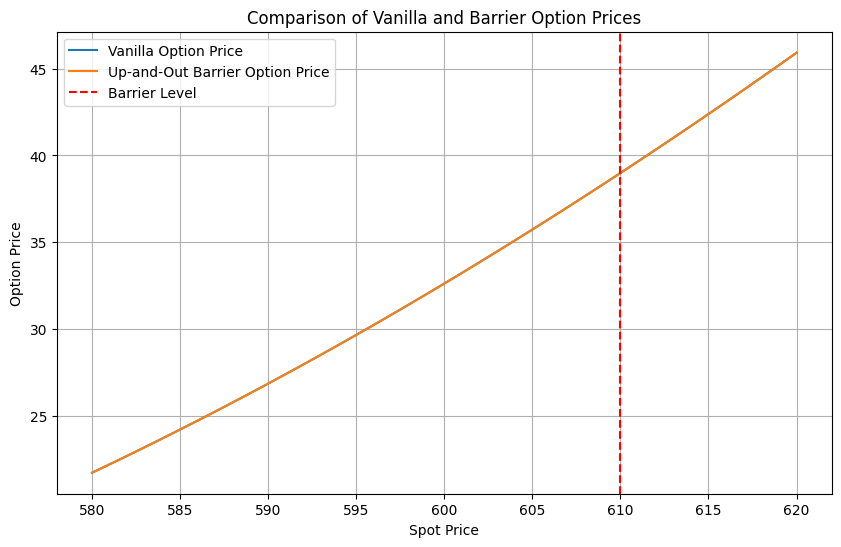

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
spot_prices = np.linspace(580, 620, 100)
vanilla_prices = []
barrier_prices = []

# Initialize the option
for S in spot_prices:
    option = FXBarrierOption(
        spot_price=S,
        strike_price=595,
        time_to_maturity=0.5,
        volatility=0.15,
        risk_free_rate=0.03,
        barrier_level=610,
        barrier_type='down-and-out'
    )
    vanilla_prices.append(option.calculate_vanilla_price(option_type='call'))
    barrier_prices.append(option.calculate_barrier_price(option_type='call'))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(spot_prices, vanilla_prices, label='Vanilla Option Price')
plt.plot(spot_prices, barrier_prices, label='Up-and-Out Barrier Option Price')
plt.axvline(610, color='red', linestyle='--', label='Barrier Level')
plt.title('Comparison of Vanilla and Barrier Option Prices')
plt.xlabel('Spot Price')
plt.ylabel('Option Price')
plt.legend()
plt.grid()
plt.show()
